Coding Assignemnt 3: https://liangfgithub.github.io/F21/coding3.pdf

## Part I : Select optimal span for loess


#### [Part I 1. Prepare Loess Function](#part1_1)
#### [Part I 2. Test Loess Function](#part1_2)
#### [Part I 3. Results](#part1_3)

<!-- #### [Part I 4. a](#part1_4)
#### [Part I 5. a](#part1_5)
#### [Part I 6. a](#part1_6)
#### [Part I 7. a](#part1_7) -->

### Abbrevations:
- LOESS: Locally Estimated Scatterplot Smoothing
- LOO-CV: Leave One Out- Cross Validation
- GCV: Generalized Cross Validation

### Terminologies:
1. Smoother Matrix:

    - Matrix that maps $y$ to $\hat{y}$
    
    > $\hat{y} = X\hat{\beta} = X_{n x p}(X^{t}X)^{-1}_{p x p}X^{t}_{p x n}y$
    
    > $\hat{y}_{n x 1} = S_{n x n}y_{n x 1}$
    
    - Here, $S= X(X^{t}X)^{-1}X^{t}$ does not depend on y, it only depends on X.


2. Leave One Out Cross Validation:
> $LOO-CV(\hat{f})=\frac{1}{N}\sum_{i=1}^{N}\left[y_i - \hat{f}^{[-i]}(x_i)\right]^2
= \frac{1}{N}\sum_{i=1}^{N}\left[\frac{y_i - \hat{f}(x_i)}{1-S_{\lambda}(i, i)}\right]^2$

    - Where $\hat{f}^{[-i]}$ denotes the model learned based on n-1 samples meaning leaveing the i-th sample out.
    - $S_{i,i}$ is the (i, i)-th entry of the smoothing matrix S.
    - $\hat{f}(x_i)$ is equivalent to $\hat{y}_{i}$
    - This makes LOO-VS faster than general m-fold CV.


3. Generalized Cross Validation:
> $GCV(\hat{f})= \frac{1}{N}\sum_{i=1}^{N}\left[\frac{y_i - \hat{f}(x_i)}{1-trace(S)/N}\right]^2$

4. Locally Estimated Scatterplot Smoothing:
    - Here, the tuning parameter is the span
    - Large value of span induces high bias and lower variance, and vice-versa

    > <img src="https://rafalab.github.io/dsbook/ml/img/loess-multi-span-animation.gif" style="height: 400px;">



References:
1. https://liangfgithub.github.io/Notes/lec_W5_NonlinearRegression.pdf
2. https://rafalab.github.io/dsbook/smoothing.html
3. https://towardsdatascience.com/loess-373d43b03564

### Loess Algorithm:

Step 1: Choose neighborhood points
> The $\alpha n$ points, those with $|x_{i} - x|$ smallest, are called the neighborhood of $x_{0}: N(x_{0})$

Step 2: Fit weighted least-squares linear regression
> $\hat{f}(x) = \hat{\beta}_{0} + \hat{\beta}_{1} (x - x_{0})$ is fit in $N(x_{0}$ points

> Cost function $=\sum_{x_{i} \epsilon N(x_0)}w_{i}\left[y_i - \beta_{0} - \beta_{1}(x_i - x_0)\right]^2$

where, $w_i = (1-u^{3}_{i})^3$
with $u_i = \frac{|x_i - x_0|}{max_{N(x_0)} |x_j - x_0|}$
 
 means $w_i = 0$ if $|u| \geqslant 1$ and
 $(1-u^{3}_{i})^3$  if $|u| < 1$
 - Larger distances will have lower weights


### Linear Regression in Loess

The smoother matrix is of the below form:
- Matrix that maps $y$ to $\hat{y}$
    
    > $\hat{y} = X\hat{\beta} = X_{n x p}(X^{t}WX)^{-1}_{p x p}X^{t}W_{p x n}y$
    
    > $\hat{y}_{n x 1} = S_{n x n}y_{n x 1}$
    
    - Here, $S= X(X^{t}WX)^{-1}X^{t}W$ does not depend on y, it only depends on X.
    - The weight matrix W has all the calculated weights in the diagonal with all other elements set to zero.

### <a id='part1_1'>Part I 1.Prepare Loess Function</a>

In [244]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from loess.loess_1d import loess_1d
import csaps

In [18]:
df = pd.read_csv('Coding3_data.csv')
df.head(2)

,x,y
0,0.009496,2.692822
1,0.039996,0.566787


In [241]:
def tricubic(u):
    """
    u: normalized vector
    1. output array w is created with dimensions equal to the input array
    2. indexing array is created to remain in the function's domain
    """
    w = np.zeros_like(u)
    idx = (u >= -1) & (u <= 1)
    w[idx] = np.power(1.0 - np.power(np.abs(u[idx]), 3), 3)
    return w

class Loess(object):
       
    @staticmethod
    def normalize_array(array):
        """
        function to normalize input array
        """
        min_val = np.min(array)
        max_val = np.max(array)
        return (array - min_val) / (max_val - min_val), min_val, max_val
    
    def __init__(self, xx, yy, degree=0):
        self.n_xx, self.min_xx, self.max_xx = self.normalize_array(xx)
        self.n_yy, self.min_yy, self.max_yy = self.normalize_array(yy)
        self.degree = degree
        
    @staticmethod
    def get_min_range(distances, window):
        """
        distances: array of distances
        window: minimal-distance window
        """
        min_idx = np.argmin(distances)
        n = len(distances)
        if min_idx == 0:
            return np.arange(0, window)
        if min_idx == n-1:
            return np.arange(n - window, n)

        min_range = [min_idx]
        while len(min_range) < window:
            i0 = min_range[0]
            i1 = min_range[-1]
            if i0 == 0:
                min_range.append(i1 + 1)
            elif i1 == n-1:
                min_range.insert(0, i0 - 1)
            elif distances[i0-1] < distances[i1+1]:
                min_range.insert(0, i0 - 1)
            else:
                min_range.append(i1 + 1)
        return np.array(min_range)
    
    @staticmethod
    def calculate_weights(distances, span):
        """
        distances: array of distances
        span: minimal-distance window
        """
        max_dist = np.max(distances[span])
        weights = tricubic(distances[span] / max_dist)
        return weights
    
    def normalize_x(self, value):
        return (value - self.min_xx) / (self.max_xx - self.min_xx)
    
    def denormalize_y(self, value):
        return value * (self.max_yy - self.min_yy) + self.min_yy

    def estimate(self, x, window, degree=0):
        """
        x: new data point
        window: number of nearest values
        wm: weights matrix
        """
        n_x = self.normalize_x(x)
        distances = np.abs(self.n_xx - n_x)
        min_range = self.get_min_range(distances, window)
        weights = self.calculate_weights(distances, min_range)

        wm = np.multiply(np.eye(window), weights)
        # Perform polynomial regression if degree is greater than 1
        xm = np.ones((window, degree + 1))

        xp = np.array([[math.pow(n_x, p)] for p in range(degree + 1)])
        for i in range(1, degree + 1):
            xm[:, i] = np.power(self.n_xx[min_range], i)

        ym = self.n_yy[min_range]
        xmt_wm = np.transpose(xm) @ wm
        beta = np.linalg.pinv(xmt_wm @ xm) @ xmt_wm @ ym
        y = (beta @ xp)[0]

            
        return self.denormalize_y(y)
    

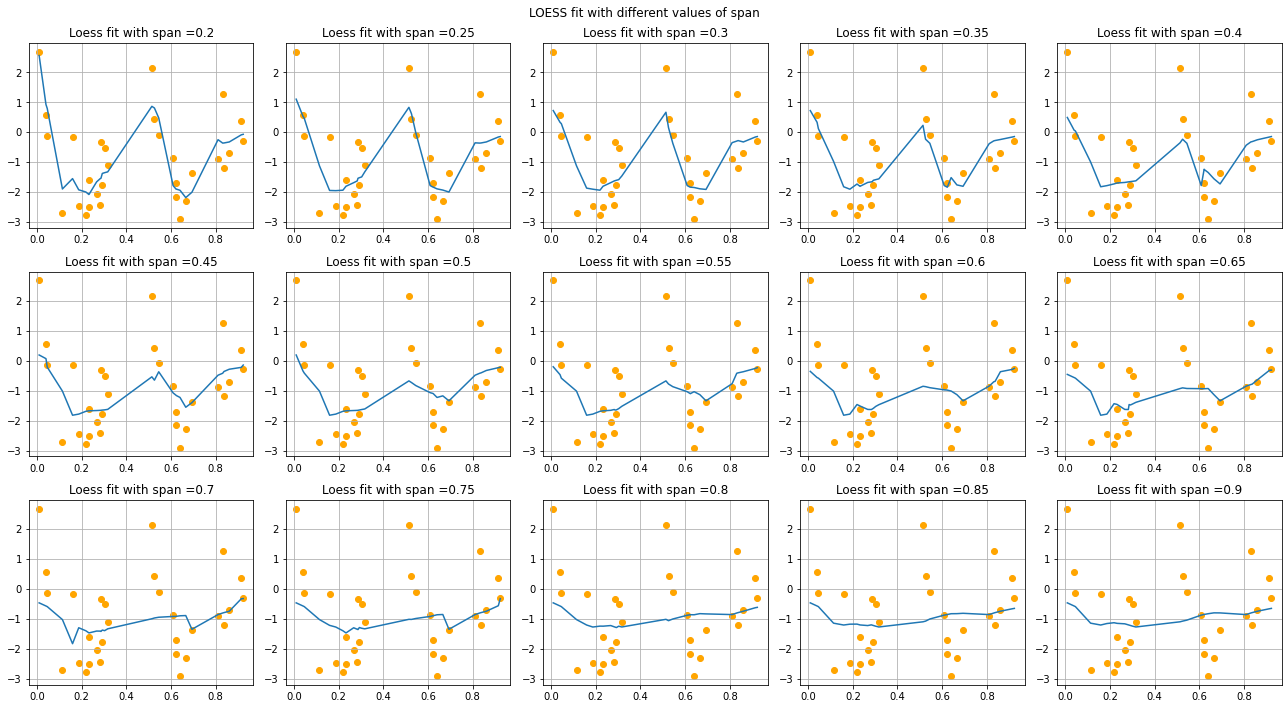

In [539]:
span_range = np.arange(0.20, 0.95, 0.05)
span_range = np.round(span_range,2)

fig, ax = plt.subplots(3, 5, figsize=(18, 10))
plt.suptitle('LOESS fit with different values of span')

z = 0
k = 0

for span in span_range:
    my_pred = {}
    for i in df.x:
        xx = df.x[(df.x >= i-(span/2)) & (df.x <= i+(span/2))]
        yy = df.y[(df.x >= i-(span/2)) & (df.x <= i+(span/2))]
        loess = Loess(xx.tolist(), yy.tolist())
        y_pred = []
        
        y = loess.estimate(i, window=len(xx), degree=0)
        my_pred.update({i:y})
          
    if z==5:
        k+=1
        z=0
        
    ax[k][z].plot(my_pred.keys(), my_pred.values())   
    ax[k][z].scatter(df.x, df.y, c='orange')
    ax[k][z].grid(True)
    ax[k][z].set_title(f'Loess fit with span ={span}')
    fig.tight_layout()
    z+=1
    
plt.show()

In [257]:
from patsy import cr

In [494]:
def smoother_matrix(x1, sp, i):
    """
    Compute the diagonal entrie of the smoother matrix S and store it in a vector 'lev'
    x1: n-by-1 feature vector
    sp: a numerical value for 'span'

    """
    x = x1[(x1 >= i-(sp/2)) & (x1 <= i+(sp/2))]
    y = np.zeros(len(x))
    idx = x.tolist().index(i)
    y[idx] = 1
    sp = cr(x, df=len(x), constraints="center")
    trace_s = np.trace(sp)
    s_i = np.sum(y.dot(sp))
    return trace_s, s_i

In [495]:
smoother_matrix(df.x, 0.20, df.x[2])

(1.3462491183023149, 0.20644296465770373)

### <a id='part1_2'>Part I 2. Test Loess Function</a>

In [496]:
def onestep_CV(sp):
    
    #  1) Fit a loess model y1 ~ x1 with span = sp, and extract the corresponding residual vector
    my_pred = {}
    for i in df.x:
        xx = df.x[(df.x >= i-(span/2)) & (df.x <= i+(span/2))]
        yy = df.y[(df.x >= i-(span/2)) & (df.x <= i+(span/2))]
        loess = Loess(xx.tolist(), yy.tolist())
        y_pred = []
        
        y = loess.estimate(i, window=len(xx), degree=0)
        my_pred.update({i:y})
    
    #  2) Call smoother_matrix to obtain the diagonal entries of S
    #  3) Compute LOO-CV and GCV using formula from lecture notes
    LOO_CV = []
    GCV = []
    for i in df.x:
        trace_s, s_i = smoother_matrix(df.x, sp, i)
#         print(s_i, sp, i)
        LOO_CV_i = np.mean((np.subtract(list(my_pred.values()), df.y.tolist())/(1-s_i))**2)
#         if not LOO_CV_i > 20:
        LOO_CV.append(LOO_CV_i)
        
        GCV_i = np.mean((np.subtract(list(my_pred.values()), df.y.tolist())/(1-trace_s/len(df.x)))**2)
        GCV.append(GCV_i)
        
    return np.mean(LOO_CV), np.mean(GCV)

In [497]:
LOO_CV = [onestep_CV(sp)[0] for sp in span_range]
GCV = [onestep_CV(sp)[1] for sp in span_range]

In [498]:
data = {'LOO_CV':LOO_CV,
        'GCV': GCV,
        'span': span_range}
result_df = pd.DataFrame(data)

### <a id='part1_3'>Part I 3. Results</a>

In [504]:
result_df

,LOO_CV,GCV,span
0,22.808799,2.365594,0.20
1,8.248848,2.495097,0.25
2,7.590359,2.621467,0.30
3,4.736462,2.716395,0.35
4,5.073215,2.841489,0.40
5,4.565437,2.982878,0.45
6,5.078600,3.150375,0.50
7,4.810738,3.305587,0.55
8,5.017686,3.534250,0.60
9,4.873002,3.857766,0.65


In [505]:
result_df[result_df.LOO_CV == min(result_df.LOO_CV)]

,LOO_CV,GCV,span
14,3.791642,5.130355,0.9


In [506]:
result_df[result_df.GCV == min(result_df.GCV)]

,LOO_CV,GCV,span
0,22.808799,2.365594,0.2


- We can see that at span 0.2, GCV error is minimum, hence we will use span as 0.2

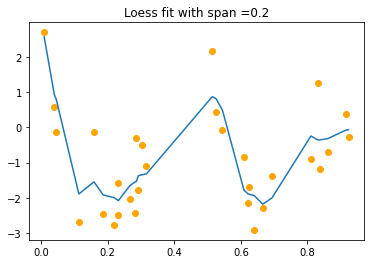

In [507]:
for span in [0.2]:
    my_pred = {}
    for i in df.x:
        xx = df.x[(df.x >= i-(span/2)) & (df.x <= i+(span/2))]
        yy = df.y[(df.x >= i-(span/2)) & (df.x <= i+(span/2))]
        loess = Loess(xx.tolist(), yy.tolist())
        y_pred = []
        
        y = loess.estimate(i, window=len(xx), degree=0)
        my_pred.update({i:y})
        
    plt.plot(my_pred.keys(), my_pred.values())   
    plt.scatter(df.x, df.y, c='orange')
    plt.title(f'Loess fit with span ={span}')
    plt.show()

In [522]:
ax

array([[<AxesSubplot:title={'center':'Loess fit with span =0.2'}>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:title={'center':'Loess fit with span =0.25'}>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:title={'center':'Loess fit with span =0.3'}>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]],
      dtype=object)